[TNG API LINK](https://www.tng-project.org/data/docs/api/)

In [1]:
import requests
import matplotlib.pyplot as mpl
import numpy as np
import h5py
%matplotlib inline

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"9af02c30810f12be44f17ad2bd4b6510"}

sim_name = 'TNG100-1-Dark'
redshift = 0.0
base_query = f'/api/{sim_name}/snapshots/z={redshift}'

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r


In [2]:
r = get(baseUrl)
r['simulations']

names = [sim['name'] for sim in r['simulations']]

In [3]:
i = names.index(sim_name)
sim = get(r['simulations'][i]['url'] )
snaps = get( sim['snapshots'] )


snap = get( snaps[-1]['url'] )

In [4]:
subs = get( snap['subhalos'], {'limit':20, 'order_by':'-mass_stars'} )

In [5]:
#i = 15 #120 mb
#i = 10 #560 mb
i = 15
sub = get( subs['results'][i]['url'] )

<HDF5 file "cutout_15.hdf5" (mode r)>


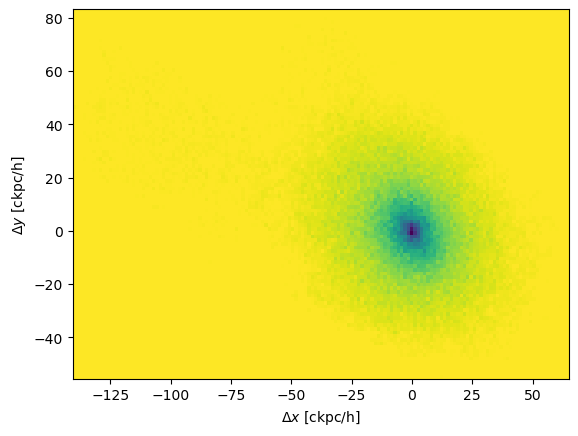

In [6]:
sub_prog_url = sub['meta']['url']
sub_prog = get(sub_prog_url)


cutout_request = {'dm':'Coordinates,SubfindDMDensity'}
cutout = get(sub_prog_url+"cutout.hdf5", cutout_request)
#cutout = get(sub_prog_url+"cutout.hdf5")

with h5py.File(cutout,'r') as f:
    print(f)
    x = f['PartType1']['Coordinates'][:,0] - sub_prog['pos_x']
    y = f['PartType1']['Coordinates'][:,1] - sub_prog['pos_y']
    z = f['PartType1']['Coordinates'][:,2] - sub_prog['pos_z']
    dens = np.log10(f['PartType1']['SubfindDMDensity'][:])
    plt.hist2d(x,y,weights=dens,bins=[150,100])
    plt.xlabel('$\Delta x$ [ckpc/h]')
    plt.ylabel('$\Delta y$ [ckpc/h]')

plt.show()

In [8]:
sub_prog_url

'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/subhalos/15/'

In [7]:
sub_prog

{'snap': 99,
 'id': 15,
 'cm_x': 309.296,
 'cm_y': 24590.8,
 'cm_z': 16744.5,
 'pos_x': 313.472,
 'pos_y': 24589.2,
 'pos_z': 16743.7,
 'halfmassrad': 26.4338,
 'len': 127980,
 'mass': 76.784,
 'massinhalfrad': 0.0,
 'massinmaxrad': 50.1562,
 'massinrad': 0.0,
 'spin_x': -314.887,
 'spin_y': -189.924,
 'spin_z': -168.534,
 'vel_x': 565.486,
 'vel_y': 1306.26,
 'vel_z': 651.383,
 'veldisp': 160.234,
 'vmax': 251.02,
 'vmaxrad': 34.2425,
 'prog_snap': 98,
 'prog_sfid': 15,
 'desc_snap': -1,
 'desc_sfid': -1,
 'fp_match_sfid': 17,
 'parent': 1,
 'grnr': 0,
 'primary_flag': 0,
 'mass_log_msun': 12.054425540279734,
 'related': {'sublink_progenitor': 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/98/subhalos/15/',
  'sublink_descendant': None,
  'parent_halo': 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/halos/0/'},
 'cutouts': {'subhalo': 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/99/subhalos/15/cutout.hdf5',
  'parent_halo': 'http://www.tng-project.org/a

In [10]:
mpb_tree = sub_prog_url + 'lhalotree/mpb.hdf5'

mpb = get(mpb_tree)


In [12]:
with h5py.File(mpb) as f:
    print(f)

<HDF5 file "lhalotree_mpb_15.hdf5" (mode r)>


In [13]:
f = h5py.File(mpb)

In [15]:
f.keys()

<KeysViewHDF5 ['Descendant', 'FileNr', 'FirstHaloInFOFGroup', 'FirstProgenitor', 'Group_M_Crit200', 'Group_M_Mean200', 'Group_M_TopHat200', 'NextHaloInFOFGroup', 'NextProgenitor', 'SnapNum', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostBound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloNumber', 'SubhaloOffsetType', 'SubhaloPos', 'SubhaloSpin', 'SubhaloVMax', 'SubhaloVel', 'SubhaloVelDisp']>

In [25]:
f['FirstProgenitor']

<HDF5 dataset "FirstProgenitor": shape (99,), type "<i4">

In [61]:
def merge(arr1, arr2):
    #arr1 and arr2 are sorted
    res = []

    while arr1 or arr2:
        if not arr1:
            res.extend(arr2)
            return res
        if not arr2:
            res.extend(arr1)
            return res

        #print(arr1, arr2, res)
        l = arr1[0]
        r = arr2[0]
        if l<=r:
            res.append(l)
            arr1 = arr1[1:]
        else:
            res.append(r)
            arr2 = arr2[1:]

    return res

def sort(arr):

    res = []

    if len(arr)==1:
        return [arr[0]]
    # elif len(arr)==2:
    #     return [min(arr), max(arr)]
    
    else:
        n2 = len(arr)//2
        left_arr = arr[:n2]
        right_arr = arr[n2:]

        #print(left_arr, right_arr)
        left_arr = sort(left_arr)
        right_arr = sort(right_arr)

        merged = merge(left_arr, right_arr)

        res.extend(merged)

    return res


array = [6,3,6,100, 8,9,2,5,7,8,1, -111]

print(array)
sorted_arr = sort(array)
print(sorted_arr)


[6, 3, 6, 100, 8, 9, 2, 5, 7, 8, 1, -111]
[-111, 1, 2, 3, 5, 6, 6, 7, 8, 8, 9, 100]


In [38]:
array = [100, 6,3,6,8,9,2,5,7,8,1, -5]

def sort(arr):
    n = len(arr)

    for i in range(n):
        curr = arr[i]
        curr_min = curr
        curr_min_idx = i
        for j in range(i, n):
            if arr[j]<curr_min:
                curr_min = arr[j]
                curr_min_idx = j

        if curr_min_idx!=i:
            arr[i], arr[curr_min_idx] = curr_min, arr[i]

    return arr

print(array)
sorted_arr = sort(array)
print(sorted_arr)


[100, 6, 3, 6, 8, 9, 2, 5, 7, 8, 1, -5]
[-5, 1, 2, 3, 5, 6, 6, 7, 8, 8, 9, 100]
